# Importing Libraries

In [1]:
import os
os.environ["MIN_LOG_CPP_LEVEL"]="2"
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PIL
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Layer,Concatenate, GlobalAveragePooling2D, Dropout, ReLU, Add, Multiply, BatchNormalization, Conv2D, Reshape, Flatten
from kerastuner import HyperModel
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
from lime import lime_image
from skimage.segmentation import mark_boundaries
import shap
import random
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report

2024-06-11 09:19:22.585454: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-11 09:19:22.585515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-11 09:19:22.587086: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Preparing data

In [4]:
# Data augmentation and rescaling
datagen = ImageDataGenerator(
    rescale=1./255,  
    rotation_range=15, 
    width_shift_range=0.1, 
    height_shift_range=0.1,  
    shear_range=0.2, 
    zoom_range=0.2,  
    brightness_range=[0.8, 1.2],  
    fill_mode='nearest', 
    validation_split=0.15 
)

# Training data generator
train_generator = datagen.flow_from_directory(
    '/kaggle/input/chest-xray-pneumonia/chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    subset='training'  
)

# Validation data generator
validation_generator = datagen.flow_from_directory(
    '/kaggle/input/chest-xray-pneumonia/chest_xray/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    subset='validation' 
)

# Test data generator
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    '/kaggle/input/chest-xray-pneumonia/chest_xray/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)


Found 4434 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
# Count the number of samples in each class for training, validation, and test sets
train_class_counts = np.unique(train_generator.classes, return_counts=True)
val_class_counts = np.unique(validation_generator.classes, return_counts=True)
test_class_counts = np.unique(test_generator.classes, return_counts=True)

print("Training class distribution:", dict(zip(train_class_counts[0], train_class_counts[1])))
print("Validation class distribution:", dict(zip(val_class_counts[0], val_class_counts[1])))
print("Test class distribution:", dict(zip(test_class_counts[0], test_class_counts[1])))


Training class distribution: {0: 1140, 1: 3294}
Validation class distribution: {0: 201, 1: 581}
Test class distribution: {0: 234, 1: 390}


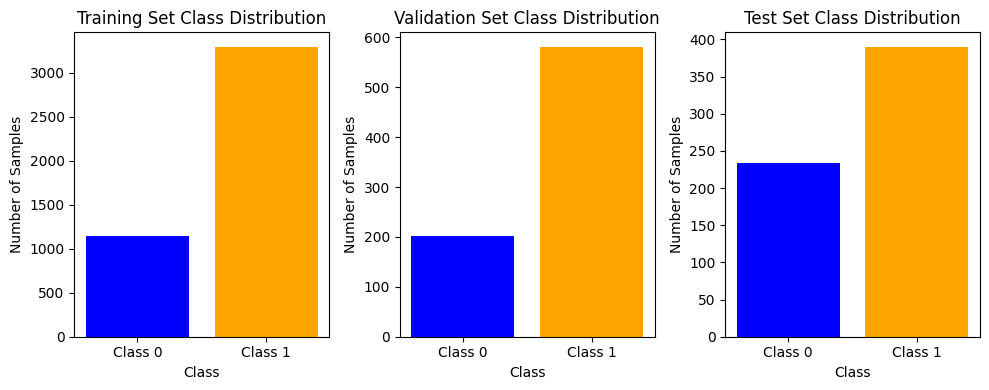

In [6]:
# Class distribution data
train_class_distribution = {0: 1140, 1: 3294}
val_class_distribution = {0: 201, 1: 581}
test_class_distribution ={0: 234, 1: 390}

# Plotting the class distribution for each dataset
fig, ax = plt.subplots(1, 3, figsize=(10,4))

# Training set
ax[0].bar(train_class_distribution.keys(), train_class_distribution.values(), color=['blue', 'orange'])
ax[0].set_title('Training Set Class Distribution')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Number of Samples')
ax[0].set_xticks([0, 1])
ax[0].set_xticklabels(['Class 0', 'Class 1'])

# Validation set
ax[1].bar(val_class_distribution.keys(), val_class_distribution.values(), color=['blue', 'orange'])
ax[1].set_title('Validation Set Class Distribution')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Number of Samples')
ax[1].set_xticks([0, 1])
ax[1].set_xticklabels(['Class 0', 'Class 1'])

# Test set
ax[2].bar(test_class_distribution.keys(), test_class_distribution.values(), color=['blue', 'orange'])
ax[2].set_title('Test Set Class Distribution')
ax[2].set_xlabel('Class')
ax[2].set_ylabel('Number of Samples')
ax[2].set_xticks([0, 1])
ax[2].set_xticklabels(['Class 0', 'Class 1'])

plt.tight_layout()
plt.show()


# Class Weights for dealing with class imbalance

In [7]:
# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights))

print("Class weights:", class_weights)

Class weights: {0: 1.944736842105263, 1: 0.6730418943533698}


# Attention

In [8]:
class MultiHeadSelfAttention(Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

class ChannelAttention(Layer):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.channels = channels
        self.reduction = reduction
        self.avg_pool = GlobalAveragePooling2D()
        self.fc1 = Dense(channels // reduction, activation='relu')
        self.fc2 = Dense(channels, activation='sigmoid')

    def call(self, inputs):
        avg_out = self.avg_pool(inputs)
        avg_out = self.fc1(avg_out)
        avg_out = self.fc2(avg_out)
        avg_out = tf.reshape(avg_out, (-1, 1, 1, self.channels))
        return inputs * avg_out

def ResidualBlock(x, filters):
    res = x
    x = Dense(filters)(x)
    x = ReLU()(x)
    x = Dense(filters)(x)
    x = Add()([x, res])
    x = ReLU()(x)
    return x


# Defining Model

In [9]:
def create_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # EfficientNetB0
    efficientnet = EfficientNetB0(include_top=False, input_tensor=inputs)
    efficientnet.trainable = False
    efficientnet_features = efficientnet.output
    
    # DenseNet121
    densenet = DenseNet121(include_top=False, input_tensor=inputs)
    densenet.trainable = False
    densenet_features = densenet.output
    
    # Concatenate features
    combined_features = Concatenate()([efficientnet_features, densenet_features])
    
    # Multi-head self-attention
    attention_features = MultiHeadSelfAttention(embed_dim=combined_features.shape[-1])(combined_features)
    
    # Channel attention
    attention_features = tf.keras.layers.Reshape((combined_features.shape[1], combined_features.shape[2], combined_features.shape[-1]))(attention_features)
    channel_attention_features = ChannelAttention(channels=combined_features.shape[-1])(attention_features)
    
    # Residual block
    residual_features = ResidualBlock(channel_attention_features, filters=combined_features.shape[-1])
    
    # Global Average Pooling
    pooled_features = GlobalAveragePooling2D()(residual_features)
    pooled_features = Dropout(0.5)(pooled_features)
    
    # Final Dense Layer
    outputs = Dense(1, activation='sigmoid')(pooled_features)
    
    model = Model(inputs, outputs)
    return model

input_shape = (224, 224, 3)
model = create_model(input_shape)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 43,619,700 (166.40 MB)

 Trainable params: 32,532,625 (124.10 MB)

 Non-trainable params: 11,087,075 (42.29 MB)

# Callbacks

In [18]:
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True,verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3,verbose=1)

# Hp Tuning

In [14]:
# Hyperparameters to search
learning_rates = [0.001, 0.0001, 0.0001]

best_accuracy = 0
best_model = None
best_lr = None

for lr in learning_rates:
    model = create_model(input_shape=(224, 224, 3))
    model.compile(optimizer=Adam(learning_rate=lr), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Callbacks
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True,verbose=1)
    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3,verbose=1)
    checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)
    
    history = model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=20,
        callbacks=[es, lr_scheduler, checkpoint],
        class_weight=class_weights
    )
    
    val_accuracy = max(history.history['val_accuracy'])
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_model = model
        best_lr = lr

print(f"Best learning rate: {best_lr}")
print(f"Best validation accuracy: {best_accuracy}")

# Save the best model
best_model.save('best_model.keras')

Epoch 1/20
  1/139 ━━━━━━━━━━━━━━━━━━━━ 2:54:34 76s/step - accuracy: 0.2812 - loss: 0.7628

I0000 00:00:1718097795.250480    4303 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718097795.373050    4303 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 60/139 ━━━━━━━━━━━━━━━━━━━━ 1:41 1s/step - accuracy: 0.5238 - loss: 7.2016 

W0000 00:00:1718097870.710358    4302 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 869ms/step - accuracy: 0.6199 - loss: 4.5123

W0000 00:00:1718097933.349167    4302 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718097965.731831    4304 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


139/139 ━━━━━━━━━━━━━━━━━━━━ 250s 1s/step - accuracy: 0.6208 - loss: 4.4928 - val_accuracy: 0.8478 - val_loss: 0.3588 - learning_rate: 0.0010
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 101s 696ms/step - accuracy: 0.8991 - loss: 0.2638 - val_accuracy: 0.8734 - val_loss: 0.2901 - learning_rate: 0.0010
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 101s 695ms/step - accuracy: 0.8926 - loss: 0.2950 - val_accuracy: 0.9156 - val_loss: 0.2063 - learning_rate: 0.0010
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 98s 678ms/step - accuracy: 0.9184 - loss: 0.2033 - val_accuracy: 0.9118 - val_loss: 0.2440 - learning_rate: 0.0010
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 98s 675ms/step - accuracy: 0.9210 - loss: 0.1976 - val_accuracy: 0.7583 - val_loss: 0.8161 - learning_rate: 0.0010
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 100s 693ms/step - accuracy: 0.9248 - loss: 0.1795 - val_accuracy: 0.9578 - val_loss: 0.1158 - learning_rate: 0.0010
Epoch 7/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 98s 674ms/step - accuracy: 0.9387 - loss

W0000 00:00:1718099024.517691    4301 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 86/139 ━━━━━━━━━━━━━━━━━━━━ 50s 949ms/step - accuracy: 0.7905 - loss: 0.4843

W0000 00:00:1718099105.090320    4301 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.8246 - loss: 0.4114

W0000 00:00:1718099151.111830    4304 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718099174.583210    4301 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


139/139 ━━━━━━━━━━━━━━━━━━━━ 215s 1s/step - accuracy: 0.8251 - loss: 0.4104 - val_accuracy: 0.9335 - val_loss: 0.1759 - learning_rate: 1.0000e-04
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 101s 696ms/step - accuracy: 0.9347 - loss: 0.1734 - val_accuracy: 0.9373 - val_loss: 0.1640 - learning_rate: 1.0000e-04
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 99s 681ms/step - accuracy: 0.9456 - loss: 0.1298 - val_accuracy: 0.9335 - val_loss: 0.1526 - learning_rate: 1.0000e-04
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 101s 690ms/step - accuracy: 0.9513 - loss: 0.1250 - val_accuracy: 0.9233 - val_loss: 0.2181 - learning_rate: 1.0000e-04
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 102s 703ms/step - accuracy: 0.9524 - loss: 0.1172 - val_accuracy: 0.9450 - val_loss: 0.1484 - learning_rate: 1.0000e-04
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 102s 701ms/step - accuracy: 0.9605 - loss: 0.0955 - val_accuracy: 0.9668 - val_loss: 0.1129 - learning_rate: 1.0000e-04
Epoch 7/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 98s 673ms/step 

W0000 00:00:1718100585.963361    4304 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 81/139 ━━━━━━━━━━━━━━━━━━━━ 53s 922ms/step - accuracy: 0.7972 - loss: 0.7430

W0000 00:00:1718100659.609676    4304 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.8320 - loss: 0.5749

W0000 00:00:1718100706.886806    4302 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718100728.461139    4303 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


139/139 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.8324 - loss: 0.5730 - val_accuracy: 0.9348 - val_loss: 0.1515 - learning_rate: 1.0000e-04
Epoch 2/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 103s 710ms/step - accuracy: 0.9343 - loss: 0.1669 - val_accuracy: 0.9463 - val_loss: 0.1182 - learning_rate: 1.0000e-04
Epoch 3/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 101s 699ms/step - accuracy: 0.9364 - loss: 0.1457 - val_accuracy: 0.9514 - val_loss: 0.1197 - learning_rate: 1.0000e-04
Epoch 4/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 98s 672ms/step - accuracy: 0.9494 - loss: 0.1355 - val_accuracy: 0.9271 - val_loss: 0.2078 - learning_rate: 1.0000e-04
Epoch 5/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 573ms/step - accuracy: 0.9584 - loss: 0.1022
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
139/139 ━━━━━━━━━━━━━━━━━━━━ 98s 678ms/step - accuracy: 0.9584 - loss: 0.1022 - val_accuracy: 0.9361 - val_loss: 0.1689 - learning_rate: 1.0000e-04
Epoch 6/20
139/139 ━━━━━━━━━━━━━━━━━━━━ 99s 684ms/step - accura

In [11]:
print("DONE ALL TRAINIG")

done training


# Model with the best hps

In [20]:
train_generator.reset()
validation_generator.reset()

In [21]:
# compile for best model with best hps
best_model = create_model(input_shape)
best_model.compile(optimizer=Adam(learning_rate=best_lr), loss='binary_crossentropy', metrics=['accuracy'])
best_history = best_model.fit(
        train_generator,
        validation_data=validation_generator,
        epochs=20,
        callbacks=[es, lr_scheduler],
        class_weight=class_weights,verbose=2
    )

Epoch 1/20


W0000 00:00:1718103289.273518    4304 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718103369.484676    4301 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718103411.800668    4301 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1718103433.250510    4304 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


139/139 - 205s - 1s/step - accuracy: 0.8829 - loss: 0.2900 - val_accuracy: 0.9348 - val_loss: 0.1686 - learning_rate: 1.0000e-04
Epoch 2/20
139/139 - 101s - 726ms/step - accuracy: 0.9296 - loss: 0.1802 - val_accuracy: 0.9284 - val_loss: 0.1710 - learning_rate: 1.0000e-04
Epoch 3/20
139/139 - 99s - 712ms/step - accuracy: 0.9452 - loss: 0.1386 - val_accuracy: 0.9527 - val_loss: 0.1344 - learning_rate: 1.0000e-04
Epoch 4/20
139/139 - 100s - 723ms/step - accuracy: 0.9549 - loss: 0.1131 - val_accuracy: 0.9246 - val_loss: 0.1800 - learning_rate: 1.0000e-04
Epoch 5/20
139/139 - 99s - 712ms/step - accuracy: 0.9524 - loss: 0.1252 - val_accuracy: 0.9540 - val_loss: 0.1183 - learning_rate: 1.0000e-04
Epoch 6/20
139/139 - 99s - 711ms/step - accuracy: 0.9513 - loss: 0.1238 - val_accuracy: 0.9591 - val_loss: 0.1080 - learning_rate: 1.0000e-04
Epoch 7/20
139/139 - 101s - 725ms/step - accuracy: 0.9585 - loss: 0.1042 - val_accuracy: 0.9731 - val_loss: 0.0800 - learning_rate: 1.0000e-04
Epoch 8/20
139/1

Plotting accuracy and loss

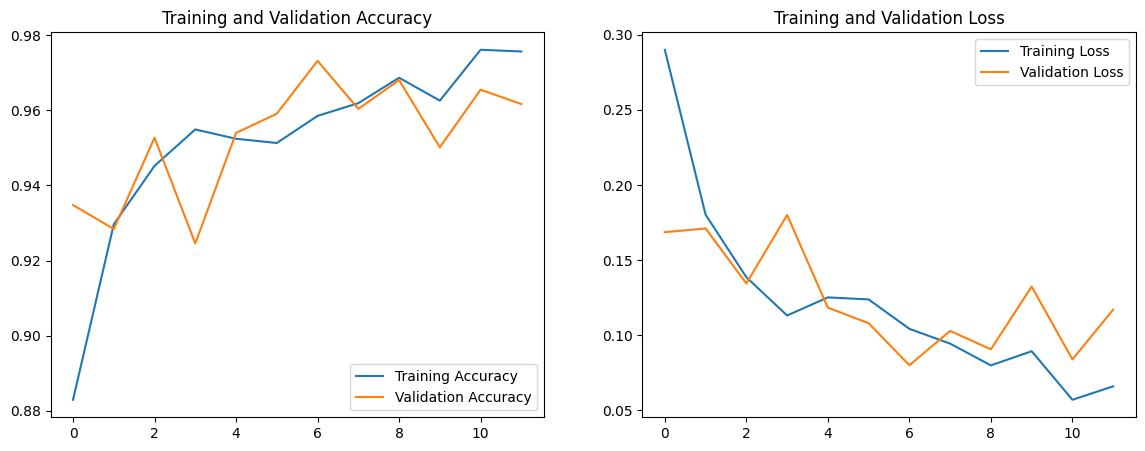

In [22]:

def plot_accuracy_loss(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    
plot_accuracy_loss(best_history)

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step


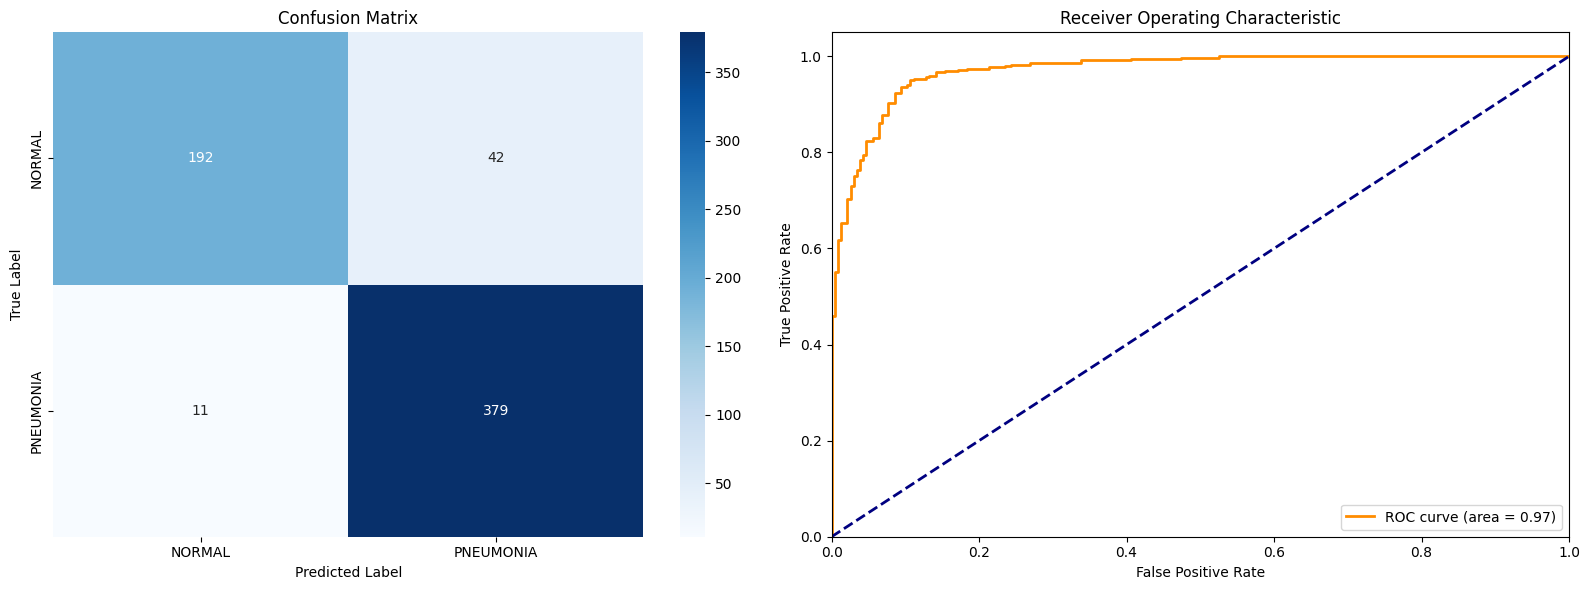

              precision    recall  f1-score   support

      NORMAL       0.95      0.82      0.88       234
   PNEUMONIA       0.90      0.97      0.93       390

    accuracy                           0.92       624
   macro avg       0.92      0.90      0.91       624
weighted avg       0.92      0.92      0.91       624



In [24]:
# Predict on the test set
test_generator.reset()
predictions = best_model.predict(test_generator)
predicted_classes = np.where(predictions > 0.5, 1, 0)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

# ROC Curve
fpr, tpr, _ = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Confusion Matrix subplot
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels, ax=axes[0])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# ROC Curve subplot
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('Receiver Operating Characteristic')
axes[1].legend(loc='lower right')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

# Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)


# LIME

In [39]:
test_generator.reset()

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━

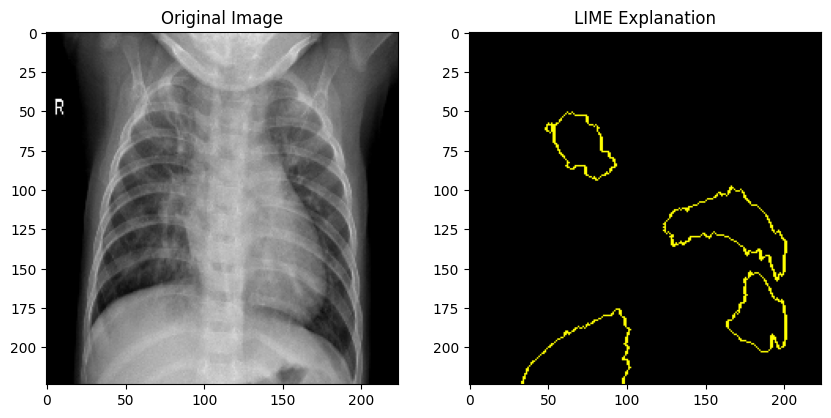

In [43]:
# Create a LIME explainer
import lime
import lime.lime_image

# from skimage.segmentation import mark_boundaries
import tensorflow as tf
from tensorflow.keras.models import load_model

explainer = lime.lime_image.LimeImageExplainer()
num_explain=1
# Explain predictions for a few images
for i in range(num_explain):
    explanation = explainer.explain_instance(explain_images[i], best_model.predict, top_labels=1, hide_color=0, num_samples=1000)
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
    # Plot the LIME explanation
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(explain_images[i])
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(mark_boundaries(temp / 255.0, mask))
    plt.title('LIME Explanation')
    plt.show()
